<a href="https://colab.research.google.com/github/mc2engel/noneq_opt/blob/mce_2025/notebooks/optimize_barrier_crossing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions ##

Since `noneq_opt` is currently private, you need to create a [Personal Access Token](https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token). Once you have the token, enter it below, and you should be able to run the cell to pip install the package.

To run with a GPU, go to `Runtime > Change runtime type` and choose `GPU`.

<!---TODO: add TPU instructions and code.--->

# Installs and Imports

In [1]:
token=''
!pip install git+https://$token@github.com/mc2engel/noneq_opt.git@mce_2025 --upgrade
!pip install -q git+https://www.github.com/google/jax-md

  Cloning https://****@github.com/mc2engel/noneq_opt.git (to revision mce_2025) to /tmp/pip-req-build-l6d02qzg
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/mc2engel/noneq_opt.git' /tmp/pip-req-build-l6d02qzg
  Running command git checkout -b mce_2025 --track origin/mce_2025
  Switched to a new branch 'mce_2025'
  Branch 'mce_2025' set up to track remote branch 'mce_2025' from 'origin'.
  Resolved https://****@github.com/mc2engel/noneq_opt.git to commit 8f97062c00fc0f927d59d50048f664846bbb4b0c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 18.7 MB/s eta 0:00:00
  Created wheel for noneq_opt: filename=noneq_opt-0.1-py3-none-any.whl size=18082 sha256=4b1f9756b661dfdf4cfcde10b2ac888f87062f759aa5cceb0402072f518b44e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-rb04kh8_/wheels/9b

In [2]:
import functools

import tqdm

from google.colab import files

import jax
import jax.numpy as jnp
import optax
import numpy as np

import jax_md

import noneq_opt.parameterization as p10n
import noneq_opt.barrier_crossing as xing
import noneq_opt.potentials as potentials

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('animation', html='jshtml')

# Simulation and training parameters

In [4]:
# Time
total_time = 10.           #@param
time_steps = 3000          #@param

# Environment
temperature = 4.           #@param
gamma = 1.                 #@param


# Trap
trap_k = 1.                 #@param
trap_schedule_degree = 16   #@param
mass = 1.                   #@param

# Molecule
mol_k_l = 1.                #@param
mol_k_r = 1.                #@param
mol_delta_e = 0.            #@param
mol_beta = 1.               #@param
mol_location = 5.           #@param

# Training
seed = 0                    #@param
batch_size = 1024           #@param
optimizer = optax.adam(.1)   #@param
training_steps = 1000       #@param

# Define our initial schedule

Text(0.5, 1.0, 'Initial Schedule')

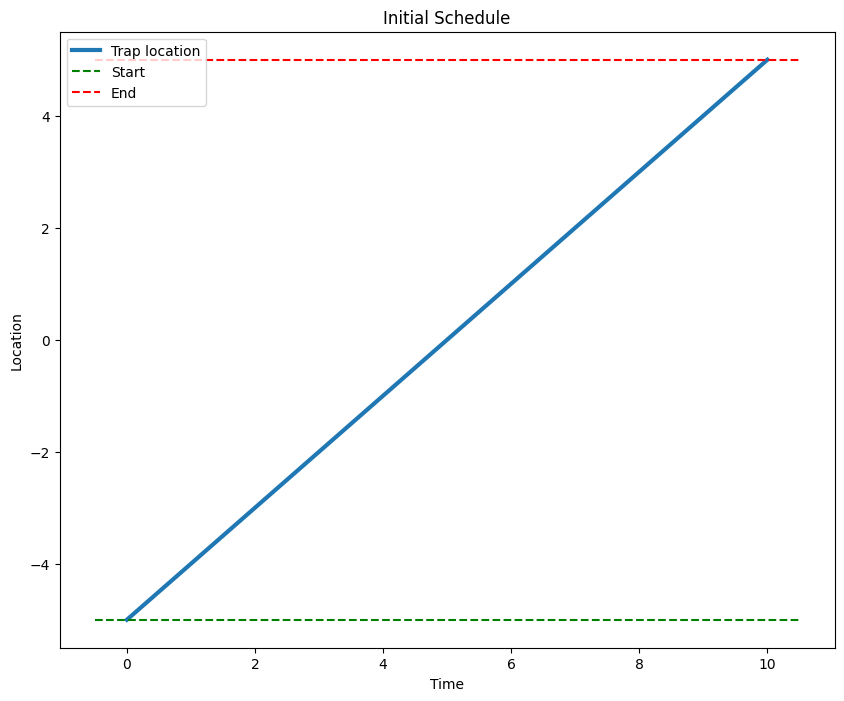

In [5]:
initial_location_schedule = p10n.ConstrainEndpoints(
    p10n.ChangeDomain(p10n.Chebyshev(jnp.zeros([1, trap_schedule_degree])),
                      x0=0., x1=total_time),
    y0=-mol_location, y1=mol_location)

def plot_schedule(schedule):
  times = jnp.linspace(0, total_time, 100)
  plt.figure(figsize=[10, 8])
  plt.plot(times, schedule(times), label='Trap location', linewidth=3)
  xlim = plt.xlim()
  plt.hlines(-mol_location, *xlim, 'g', 'dashed', label='Start')
  plt.hlines(+mol_location, *xlim, 'r', 'dashed', label='End')
  plt.xlabel('Time')
  plt.ylabel('Location')
  plt.legend()
plot_schedule(initial_location_schedule)
plt.title('Initial Schedule')

#Training

In [8]:
def seed_stream(seed):
  key = jax.random.PRNGKey(seed)
  while True:
    key, yielded = jax.random.split(key)
    yield(key)

stream = seed_stream(0)
state = optimizer.init(initial_location_schedule)

trap_fn = functools.partial(xing.potentials, k=trap_k)
molecule = xing.bistable_molecule(
    jnp.array([mol_location]), mol_k_l, mol_k_r, mol_delta_e, mol_beta)
x0 =  -mol_location * jnp.ones(1)

train_step = xing.get_train_step(optimizer,
                                 trap_fn,
                                 molecule,
                                 x0,
                                 total_time,
                                 time_steps,
                                 mass,
                                 temperature,
                                 gamma,
                                 batch_size)

summaries = []

for j in tqdm.trange(train_steps, position=0):
  state, summary = train_step(state, j, next(stream))
  summaries.append(summary)

# Plot entropy production during training.
plt.figure(figsize=[12, 8])
plt.plot([s.work.sum(-1) for s in summaries], 'r,', alpha=.1)
plt.plot([s.work.sum(-1).mean() for s in summaries], 'b-')
plt.xlabel('Training step')
plt.ylabel('Work')
plt.title('Training')
plt.show();

final_schedule = optimizer.params_fn(state)
plot_schedule(final_schedule)
plt.title('Final Schedule')
plt.show();

AttributeError: module 'noneq_opt.barrier_crossing' has no attribute 'potentials'

# Plot an animation of the final schedule

In [ ]:
plot_every = 20
max_energy = 100

times = np.linspace(0, total_time, time_steps // plot_every)
xs = jnp.linspace(-2 * mol_location, 2 * mol_location, 100)[..., jnp.newaxis]

fig = plt.figure(figsize=[12, 12])
ax = plt.axes()

schedule = optimizer.params_fn(state)
trap = trap_fn(schedule)
energy = xing.sum_potentials(trap, molecule)

def frame(j):
  ax.clear()
  time = times[j]

  positions = jnp.transpose(summary.state.position[:, j * plot_every], axes=(0, 1))

  trp = jax.vmap(trap, [0, None])(xs, time)
  mol = jax.vmap(molecule, [0, None])(xs, time)
  nrg = jax.vmap(energy, [0, None])(xs, time)
  ax.plot(xs, trp, 'r-', label='trap')
  ax.plot(xs, mol, 'b-', label='bistable molecule')
  ax.plot(xs, nrg, 'm-', label='total')
  plot = ax.scatter(positions, jax.vmap(energy, [0, None])(positions, time) + 1, c='g', marker='.', label='locations')
  ax.hist
  ax.set_ylim(-10, max_energy)
  ax.set_xlim(xs[0, 0], xs[-1, 0])
  ax.text(-2 * mol_location, -5, f'Time: {time:.2f}')
  ax.legend(loc=1)
  return plot,

frame(0)
print('Building animation...')
anim = animation.FuncAnimation(
    fig, frame, blit=True, frames=time_steps // plot_every)
plt.close(fig)
anim